# _Python for Scientific Data Analysis_


#  Bayesian Statistics and Markov Chain Monte Carlo methods

## Section 2: Tuning MCMC

**caveats** (again)

(caveat: a lot of this is HEAVILY indebted to Daniel Foreman-Mackey and Imad Pasha and in many cases is just plain copied from these sources (especially the latter in this section).  Please browse their work on https://dfm.io/ and https://prappleizer.github.io/.  I also borrowed a bit of text from Charles Greyer (U. Minnesota) )

(caveat #2: your instructor has a heavy frequentist bias by training but likes MCMC largely for its parameter space exploration and clear visualization of correlations between parameters in leading, widely-used code)



In the first section we introduced the rationale behind Bayesian statistics and the Markov Chain Monte Carlo method for sampling a complex parameter space and deriving posterior distributions.   We used a simple and highly contrived example -- a linear fit to data with underestimated errors -- to demonstrate MCMC modeling.

Now, we will do MCMC on a more complicated example and use this demonstration to explore rudimentary ideas on how to tune MCMC parameters.   We will then discuss parallel tempering with MCMC and finish with discussion of at least one major practical application of MCMC in astronomy research.

As before we start with standard import commands

In [1]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

import emcee
import corner

Another package that will be useful later is ``ptemcee`` (pronounced "tem-cee", stands for "parallel-tempering emcee"), which is a fork of the ``emcee`` package to do parallel tempering.  Don't worry about what that means right now.  However, do try to download and install the package.

E.g. 

``pip install ptemcee``

Then after installation, import this package:

In [2]:
import ptemcee

## Tuning MCMC: Fitting the Earth's Milankovich Cycles 

Now we will try to model data that are lot more complicated than a straight line.  To start with we will be using ``emcee`` as before.

Located in the "files" subdirectory is a file containing the temperature change, age, deuterium content, etc., of the Earth's atmosphere over the last several million years, calculated from measurements of ice-core samples (file name is 'ice_core_data.txt'). For these notes, we will be interested in only the age and temperature columns. 
The ages and $\Delta T$ are in the third and fifth columns, respectively. Load the data and plot the Temperature deviation (from average) against age to see what we will be trying to fit in this tutorial.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

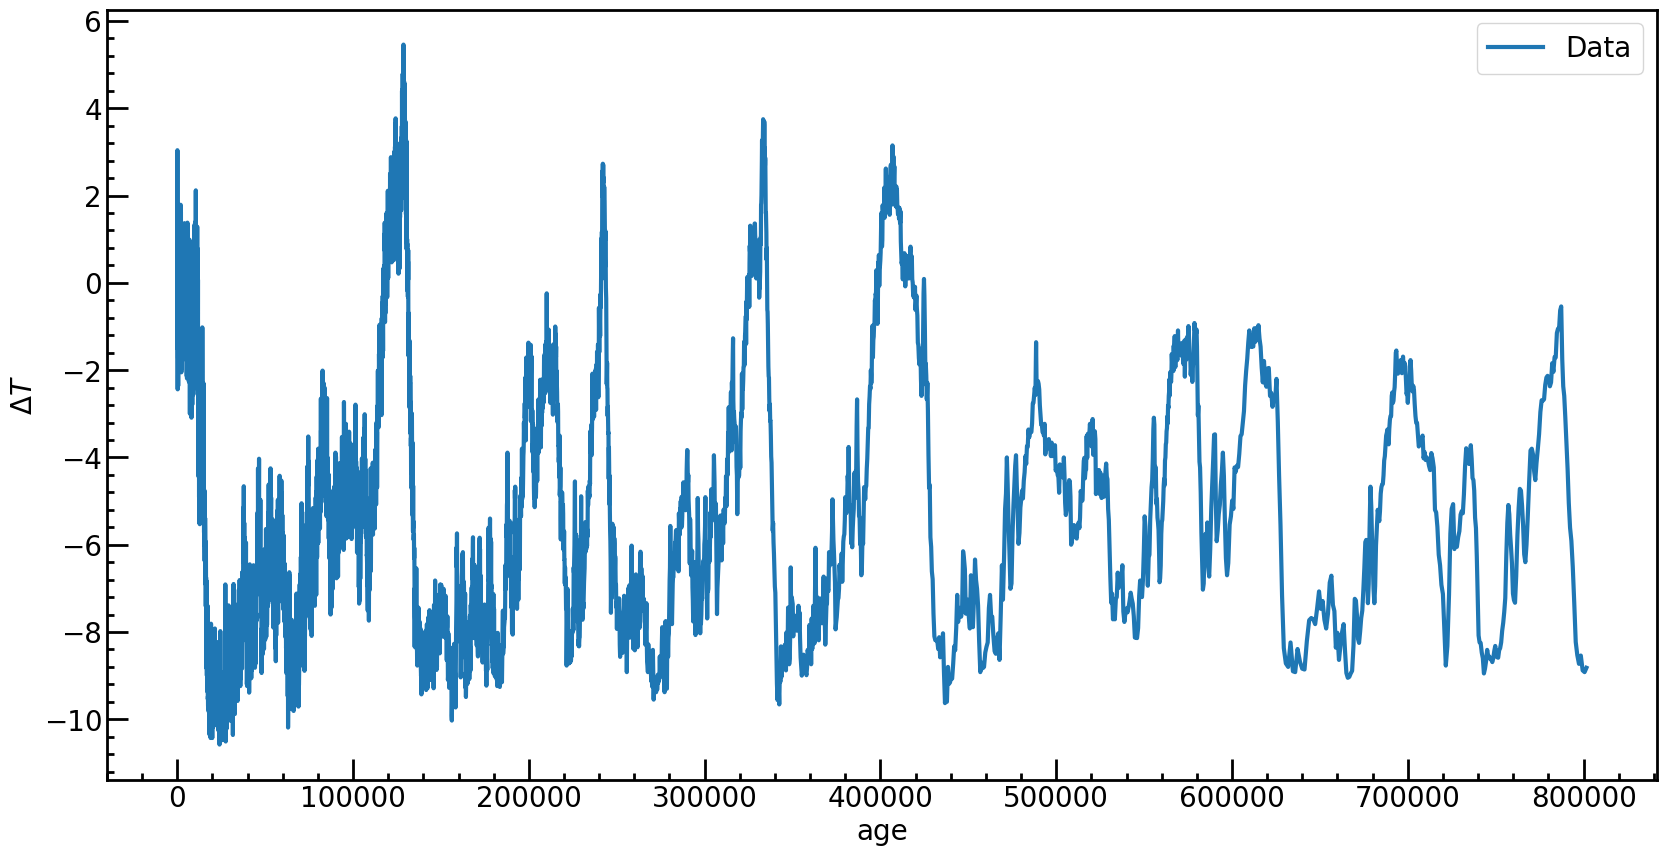

In [4]:
from matplotlib.ticker import AutoMinorLocator
directory='./files/'
ice_data = np.loadtxt(directory+'ice_core_data.txt')

age= ice_data[:,2]
T = ice_data[:,4]


fig,ax=plt.subplots()

ax.plot(age,T,label='Data',lw=3)

#formatting details
ax.set_xlabel('age',fontsize=20)
ax.set_ylabel(r'$\Delta T$',fontsize=20)
ax.tick_params(which='major',direction='in',width=2,length=15,labelsize=20)
ax.tick_params(which='minor',direction='in',width=2,length=5,labelsize=20)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
for axl in ['top','bottom','left','right']:
 ax.spines[axl].set_linewidth(2)

ax.legend(loc='best',fontsize=20)
#plt.setp(ax.spines.values(),linewidth=2)
#plt.show()


Great. Now, we can see that the temperature of Earth fluctuates a lot over its history, but that those fluctuations seem fairly periodic.  I.e. you can definitely that peaks show up about once every 100,000 years or so.   These fluctuations are due to combinations of small, but important periodic changes in the Earth's tilt (obliquity), rotational precession, orbital precession, eccentricity, and ecliptic inclination. Three of these effects were studied extensively by Milutin Milankovich and have come to be named after him. While not the only effects, they are three of the primary ones driving the fluctuations we see above. 

Those three effects are the obliquity, rotational precession, and eccentricity. For more on these effects, you can check out the wikipedia article: https://en.wikipedia.org/wiki/Milankovitch_cycles 

The article says that the periods of the Milankovich cycles are approximately 26,000 years, 41,000 years, and 100,000 years. While our model will actually end up fitting our periods, these numbers will allow us to shorten our MCMC run by introducing good priors.

We can create a basic model for describing the above fluctuations as a sum of three sinusoidal functions, which have different amplitudes and periods corresponding to roughly the Milankovich cycles. This is a crude model but will be good enough for the purposes of these notes.  

Our model will be of the form 
$$
\Delta T = a_1 \sin\left(\frac{2\pi t}{p_1}\right) + a_2 \sin\left(\frac{2\pi t}{p_2}\right) + a_3 \sin\left(\frac{2\pi t}{p_3}\right) + T_0
$$
where $a_1, a_2, a_3, p_1, p_2, p_3,$ and $T_0$ are the parameters we will be fitting for.

Here, T$_{\rm 0}$ is the offset of $\Delta$T from zero, $a_1, a_2, a_3$ are amplitudes, and $p_1, p_2, p_3$ are periods.

And now to create the functions needed for MCMC.

First, the model whose form is already discribed above:

In [5]:
def model(theta,age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0

Next, the log-likelihood.   This will simply be a comparison between the observed $\Delta$T ($y$), the predicted $\Delta$T ($y_{\rm model}$), given the error ($y_{\rm error}$):


$$
ln(\mathcal{L}(y|a_1,a_2,a_3,p_1,p_2,p_3))= -\frac{1}{2} \sum{\left(\frac{y-y_{model}}{y_{err}}\right)^{2}}
$$

In [6]:
def log_likelihood(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

Third, we need to specify the prior probability function.  As before, we will set uninformative priors:

 Reasonable bounds on the amplitudes can be drawn from the plot above (the amplitudes individually can't be greater than the overall amplitude of the final fluctuations, and $T_0$ must be within the upper and lower bounds of the data we see). 
 
 Priors on the periods are tricker.  But a good guess is that they should all be greater than about 10,000 years and less than 200,000 years.  (We will talk a bit later about evaluating from "walker plots" whether our priors might not have been great). 


In [7]:
def log_prior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    return -np.inf

Finally, the log-probability function which is the prior multiplied by the likelihood function.  As mentioned in the first lecture, doing this in log space means that the two function outputs are added.  



In [8]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

We have one or two steps left before we can run. First, MCMC needs errors on the temperature estimates for it to run but unfortunately none are provided.   Let's set a yerr array arbitrarily to 5% of the average temperature in our temperature array. 

We will want to feed our data (x,y,yerr) in as a tuple, so set data equal to a tuple of our age, temperature and temperature error arrays. 

We also need to set a value for nwalkers, which determines how many walkers are initialized in our MCMC. Let's use 500.

We need a variable called initial, which is an initial set of guesses (this will be the first theta, where the MCMC starts). 

Finally we need p0, which is the methodology of stepping from one place to a grid to the next ( I will provide this). 

In [9]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 100
niter = 400
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

We are now ready to run the MCMC. In the previous section, we ran MCMC for a set number of iterations and then threw away the first 100 steps as "burn-in".  This time will take a slightly different strategy, running MCMC for 100 steps, re-set the sampler with these new starting positions, and then running again for a full number of iterations.

In [10]:
def main(p0,nwalkers,niter,ndim,log_probability,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100,progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter,progress=True)
    
    print("finished!")

    return sampler, pos, prob, state

The sampler here contains all the outputs of the MCMC, including the walker chains and the posteriors. We will talk a little bit later about evaluating whether an MCMC has "converged," but for now let's quickly extract a random sampling of our posteriors and plot them over our data.

In [11]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,log_probability,data)

Running burn-in...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 121.68it/s]


Running production...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 124.90it/s]

finished!


In [12]:
def plotter(sampler,age=age,T=T):
    fig,ax=plt.subplots(figsize=(20,6))
    #plt.ion()
    ax.plot(age,T,label='Data',lw=3)
    samples = sampler.flatchain
    
    #select 100 models from the posterior distribution
    for theta in samples[np.random.randint(len(samples), size=100)]:
        ax.plot(age, model(theta, age), color="orange", alpha=0.1,lw=2)
  #  ax.set_ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#formatting
    ax.set_xlabel('age',fontsize=20)
    ax.set_ylabel(r'$\Delta T$',fontsize=20)
    ax.tick_params(which='major',direction='in',width=2,length=15,labelsize=20)
    ax.tick_params(which='minor',direction='in',width=2,length=5)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.legend(loc='best',fontsize=20)
    for axl in ['top','bottom','left','right']:
      ax.spines[axl].set_linewidth(2)
    

    #plt.show();

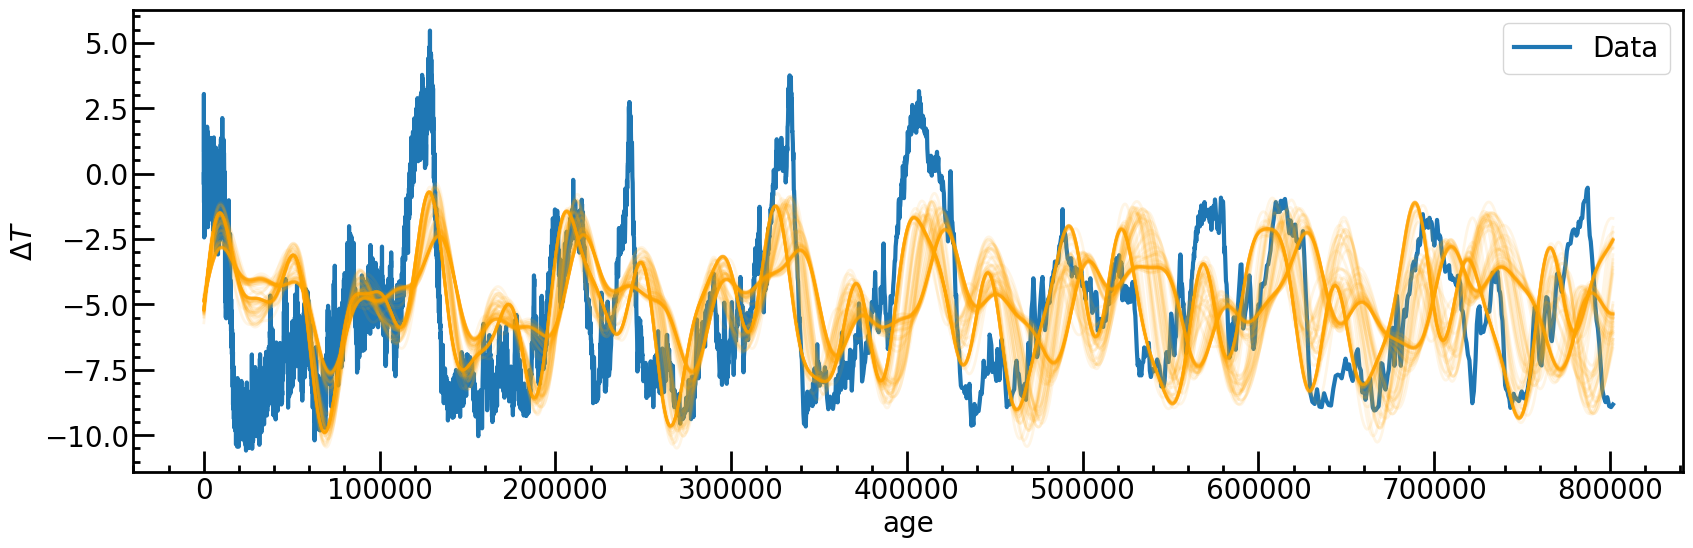

In [13]:
#sampler= main(p0)
plotter(sampler)

We can see from our plot that our simplistic model (of three sinusoids) is not perfect, but it sort-of matches the data. We can see that from the hundred samples we drew from the posteriors, they all seem to overlap over each other pretty well. We can see the exact values of our parameters as well: 


In [14]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 7.96053931e-01,  2.10065737e+00,  1.89755725e+00,  2.44617816e+04,
        3.97485220e+04,  9.61815768e+04, -5.20522393e+00])

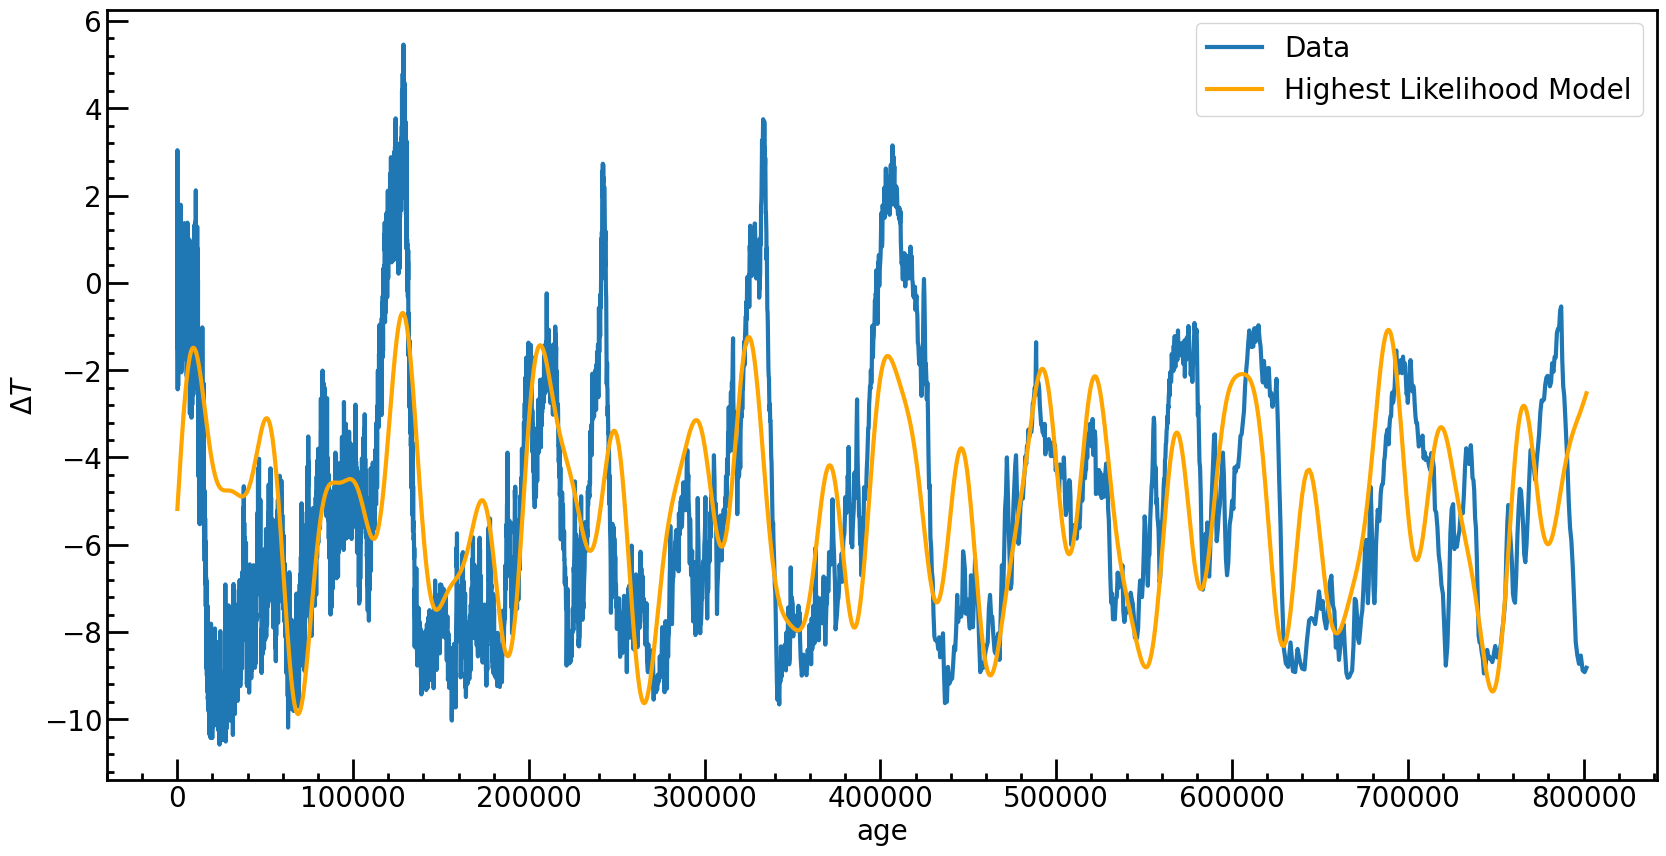

Theta max:  [ 7.96053931e-01  2.10065737e+00  1.89755725e+00  2.44617816e+04
  3.97485220e+04  9.61815768e+04 -5.20522393e+00]


In [15]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)

fig,ax=plt.subplots()
ax.plot(age,T,label='Data',lw=3)
ax.plot(age,best_fit_model,label='Highest Likelihood Model',color='orange',lw=3)
ax.set_xlabel('age',fontsize=20)
ax.set_ylabel(r'$\Delta T$',fontsize=20)
ax.tick_params(which='major',direction='in',width=2,length=15,labelsize=20)
ax.tick_params(which='minor',direction='in',width=2,length=5)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.legend(loc='best',fontsize=20)
for axl in ['top','bottom','left','right']:
      ax.spines[axl].set_linewidth(2)
plt.show()
print ('Theta max: ',theta_max)

So we find that our amplitudes are 0.796, 2.1, and 1.89 (seems about right, they should be about 5 or less), we get periods of 24,500 years, 40,000 years, and 96,000 years (pretty close to our predictions of 26,000, 41,000, and 100,000 years), and a $T_0$ of -5.2 degrees.

**note** (these numbers are going to change each time you run this notebook!)

### Posterior Spread
We can use the corner.py module to visualize 1D and 2D spreads between the parameters we are testing, and get some uncertainties on our paraemter estimations.

First, we visualize and then estimate the autocorrelation time ...

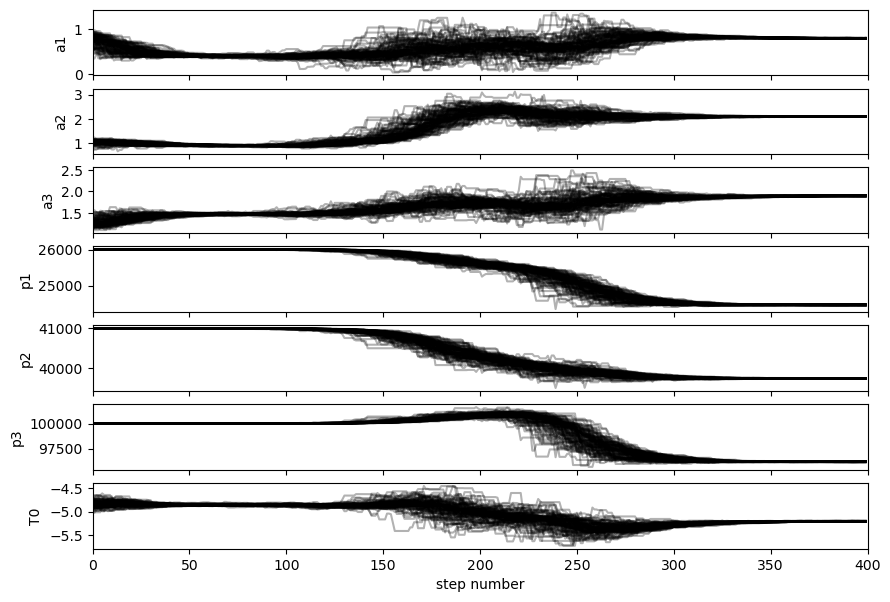

In [16]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['a1','a2','a3','p1','p2','p3','T0']

for i in range(0,ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.set_xlabel("step number");
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

We see a couple of things, most notably that a lot of the parameters are still changing at the end of our simulation (e.g. $p_1$ and $p_3$).

Now let's get the autocorrelation time(s).

In [17]:
tau=sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [46.92065541 50.12554873 54.45031994 53.7102624  53.96399354 49.69646921
 49.17791163]

Now, Python yells at us that we really need to run a longer chain, which is a hint that something may be amiss.   Let's thin the sample by some fraciton of the shortest time ($\sim$10).  Since we already did a burn-in, no need to discard the first 100 steps of the chain.

(4000, 7)


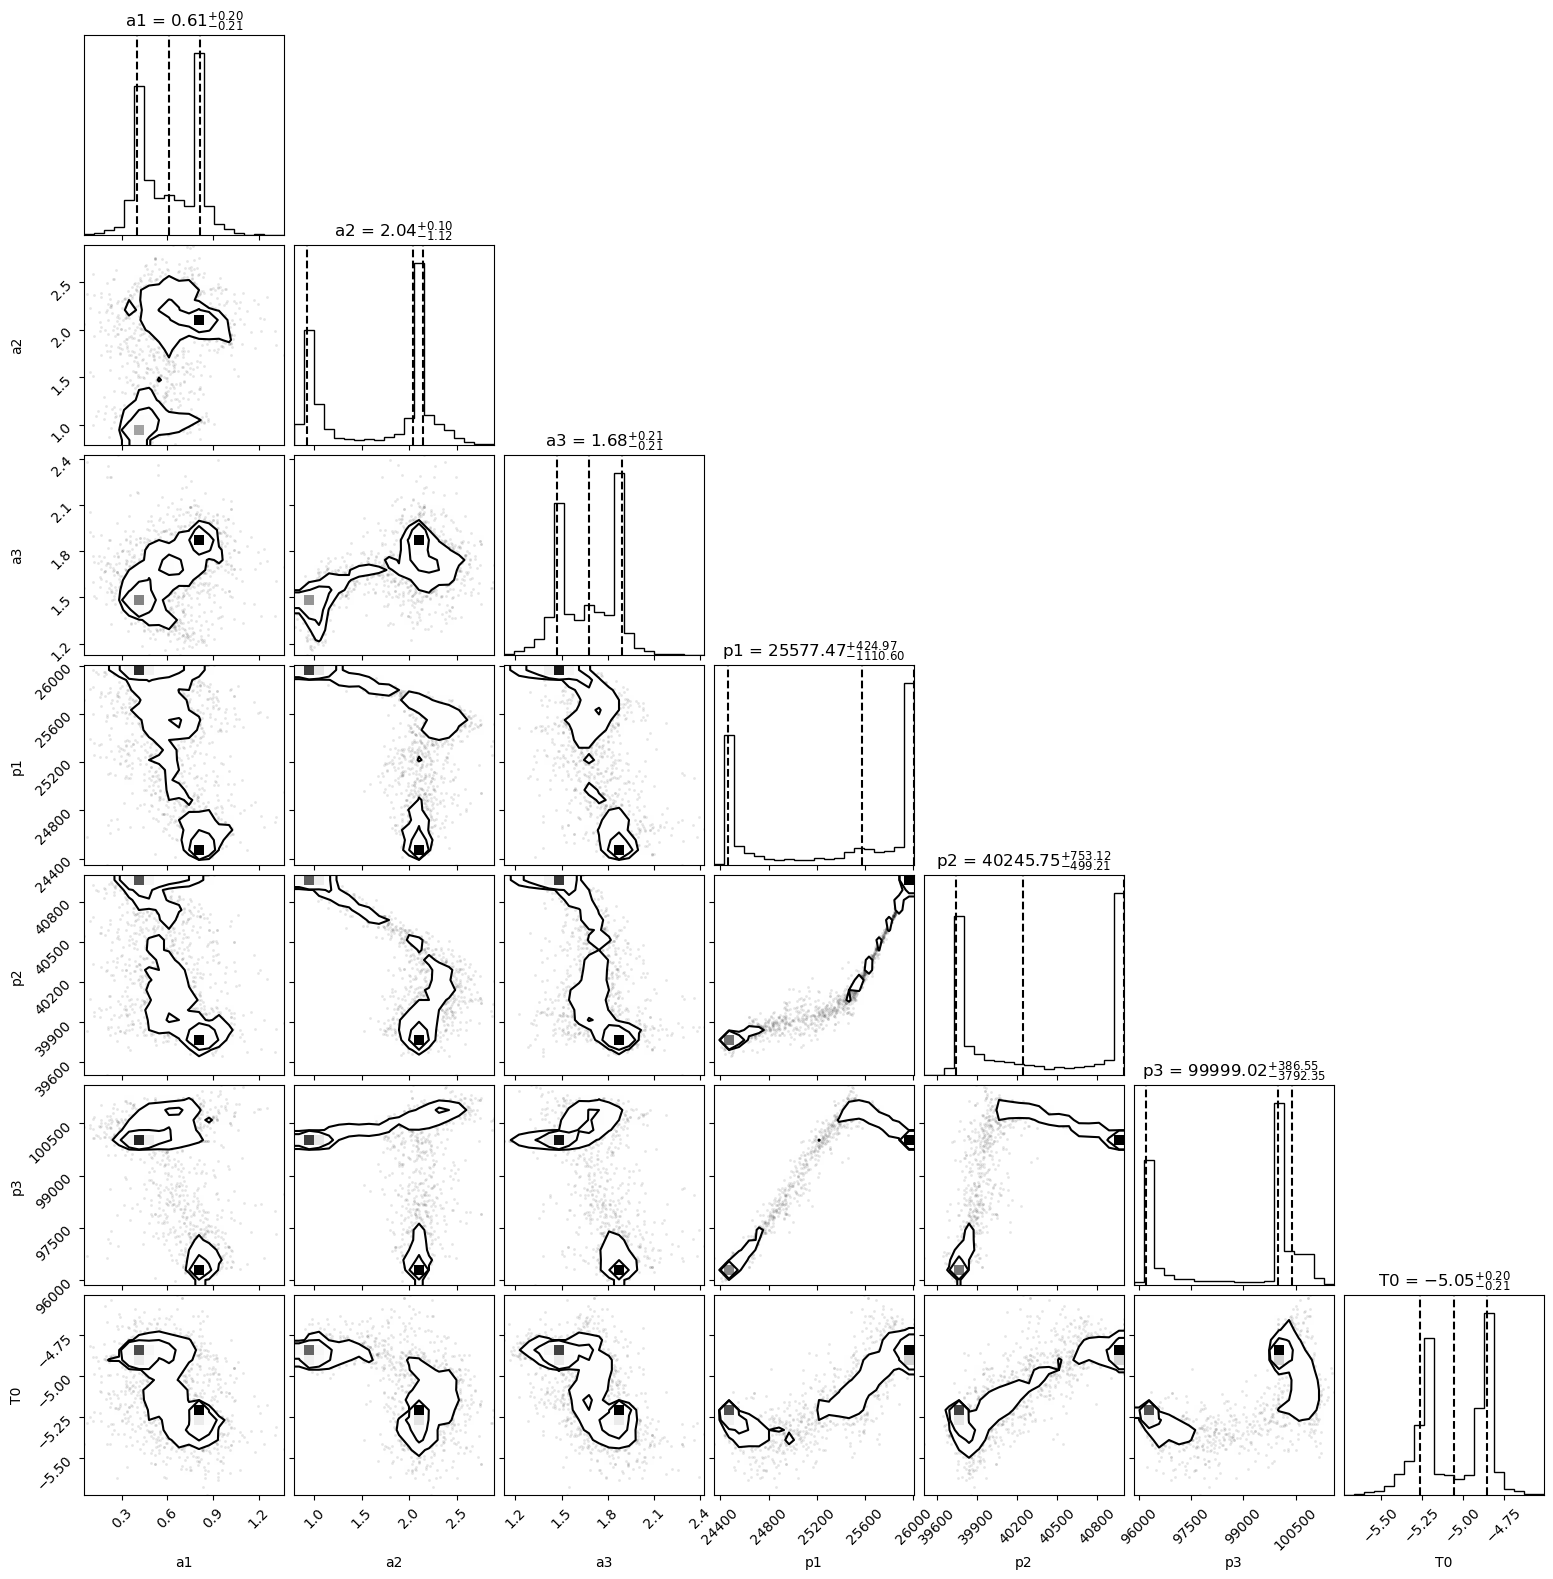

In [18]:
flat_samples=sampler.get_chain(thin=10,flat=True)
print(flat_samples.shape)
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(flat_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
#fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

While the plot visually looks cool, it does show some serious warning signs.  In particular, a lot of the fitted parameters have bimodalities (i.e. multiple peaks).   This is something we can expect given the fact that the mean value of our parameters seems to still be changing as we finished our simulation.  It is even possible that a parameters that _seems_ to be fitted well may in fact have gotten stuck in some local minimum and that there is another region of phase space that fit the data better.  

This all means that our MCMC has not _converged_ yet and we need to run longer.    

So how do we work around this problem?  First, we can increase the number of walkers to sample the phase space more densely.  Second, we can increase the number of iterations to run our simulation for longer.   Let's see if that changes anything.

Note, because we have increased the number of walkers and iterations, this will take a lot longer to run (a few minutes).

In [19]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 400 #4x more walkers
niter = 1600 #4x more iterations
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]


In [20]:
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,log_probability,data)

Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.09it/s]


Running production...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:52<00:00, 30.55it/s]

finished!


Now, we redo the same analysis as above.  First, by plotting the change in parameters for all chains vs iteration

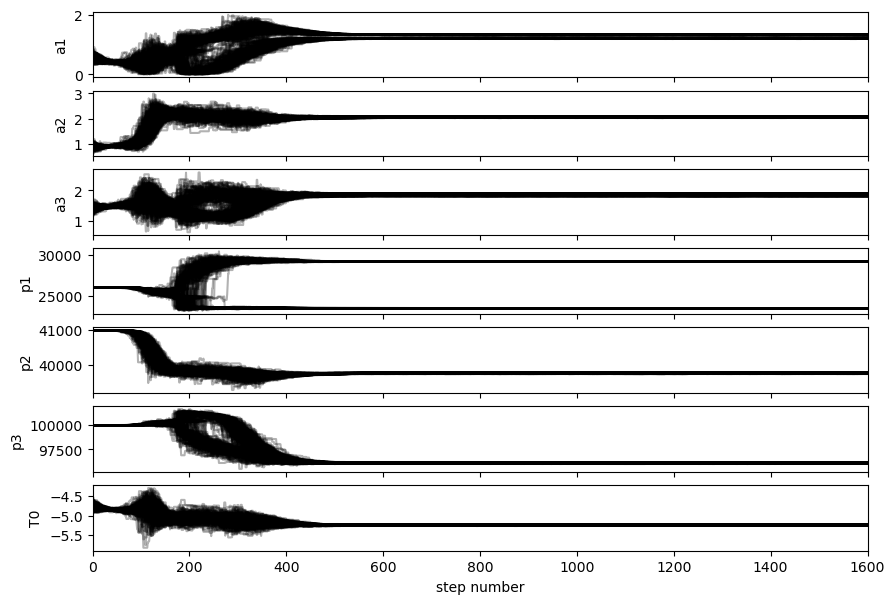

In [21]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
new_samples = new_sampler.get_chain()
labels = ['a1','a2','a3','p1','p2','p3','T0']

for i in range(0,ndim):
    ax = axes[i]
    ax.plot(new_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(new_samples))
    ax.set_ylabel(labels[i])
    #ax.set_xlabel("step number");
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

This looks good.  Each of the parameters seems to have settled down.  And we can see already that we are going to get different solutions (e.g. compare the results for $a_1$ from before). Let's look more closely ...

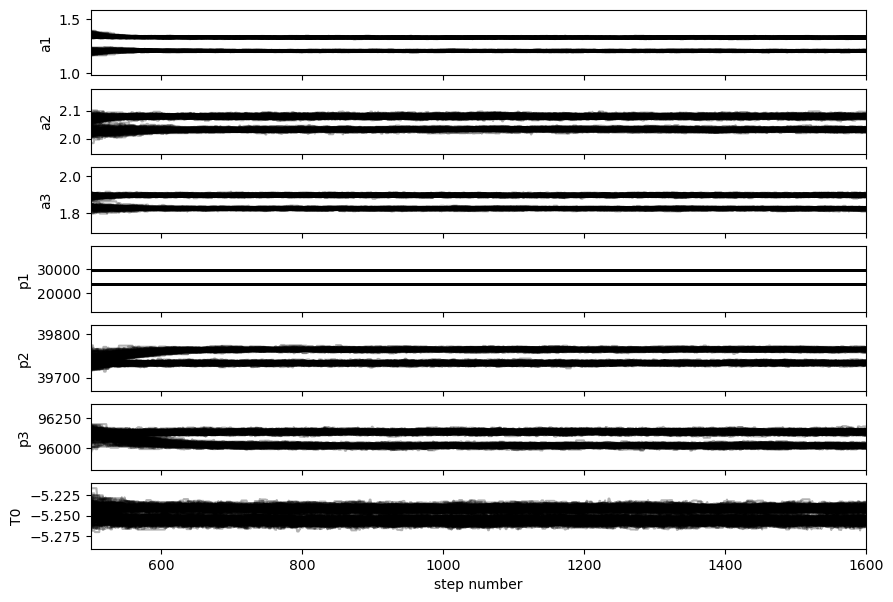

In [22]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
new_samples = new_sampler.get_chain()
labels = ['a1','a2','a3','p1','p2','p3','T0']

for i in range(0,ndim):
    ax = axes[i]
    ax.plot(new_samples[:, :, i], "k", alpha=0.3)
    #from iteration =400 onwards
    ax.set_xlim(500,len(new_samples))
    
    pars=new_samples[:, :, i]
    ax.set_ylim(-5*np.std(pars[500:])+np.mean(pars[500:]),5*np.std(pars[500:])+np.mean(pars[500:]))
    ax.set_ylabel(labels[i])
    #ax.set_xlabel("step number");
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The bimodality is more suppressed than before?

Now, the autocorrelation time.

In [23]:
tau_new=new_sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 32;
tau: [158.08139876  99.398661   161.19950038 149.93257293 117.76297026
 189.43910334 178.35134622]

Still getting yelled at by Python.  But this isn't *quite* as bad as before, although the autocorrelation time seems to have jumped.

Now, let's plot.

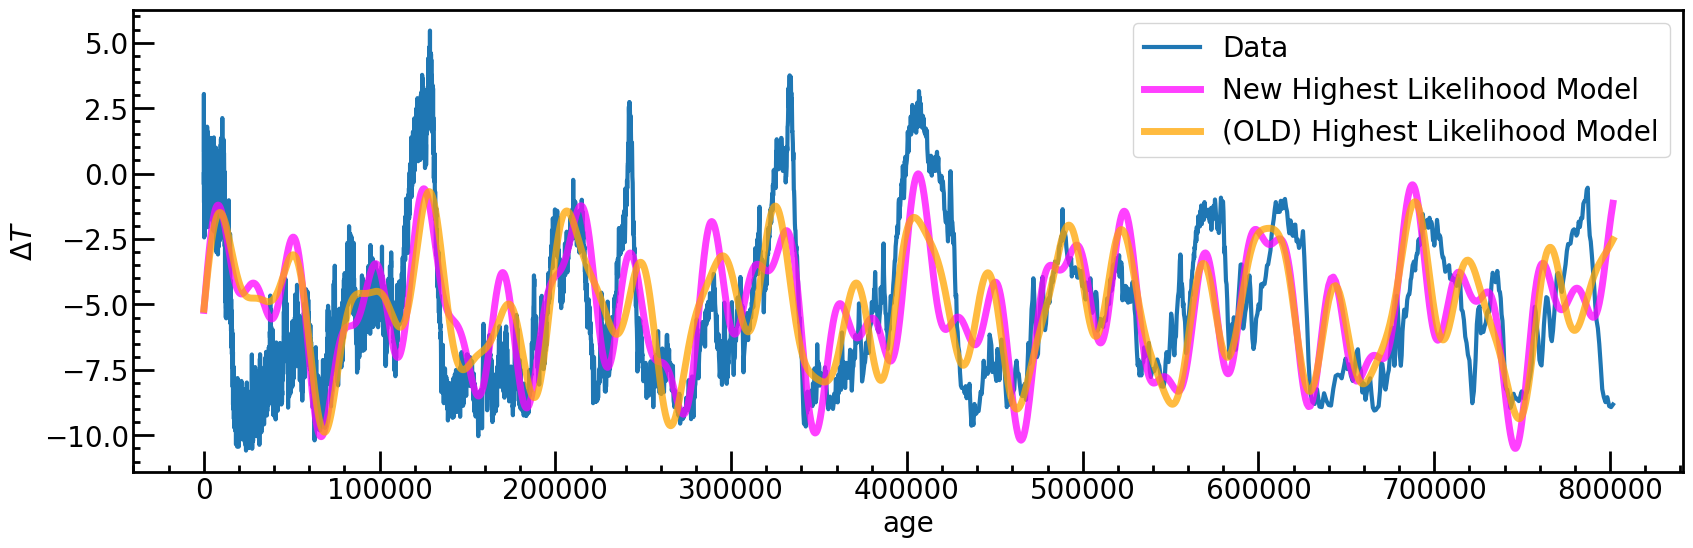

Theta max:  [ 1.32739494e+00  2.07932372e+00  1.89701915e+00  2.35214389e+04
  3.97336773e+04  9.61333115e+04 -5.25624960e+00]


In [24]:
new_samples =  new_sampler.flatchain

new_theta_max  = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
#plt.plot(age,T,label='Change in T')
#plt.plot(age,new_best_fit_model,label='Highest Likelihood Model',color='magenta',lw=5)
#plt.plot(age,best_fit_model,label='(OLD) Highest Likelihood Model',color='orange',lw=5)
#plt.legend(loc='best',fontsize=20)

fig,ax=plt.subplots(figsize=(20,6))
ax.plot(age,T,label='Data',lw=3)
ax.plot(age,new_best_fit_model,label='New Highest Likelihood Model',color='magenta',lw=5,alpha=0.75)
ax.plot(age,best_fit_model,label='(OLD) Highest Likelihood Model',color='orange',lw=5,alpha=0.75)
ax.set_xlabel('age',fontsize=20)
ax.set_ylabel(r'$\Delta T$',fontsize=20)
ax.tick_params(which='major',direction='in',width=2,length=15,labelsize=20)
ax.tick_params(which='minor',direction='in',width=2,length=5)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.legend(loc='best',fontsize=20)
for axl in ['top','bottom','left','right']:
      ax.spines[axl].set_linewidth(2)
        
plt.show()
print ('Theta max: ',new_theta_max)

So the highest likelihood model is very similar to the previous one.   But fear not: let's plot the posterior distributions and see what happens.

(16000, 7)


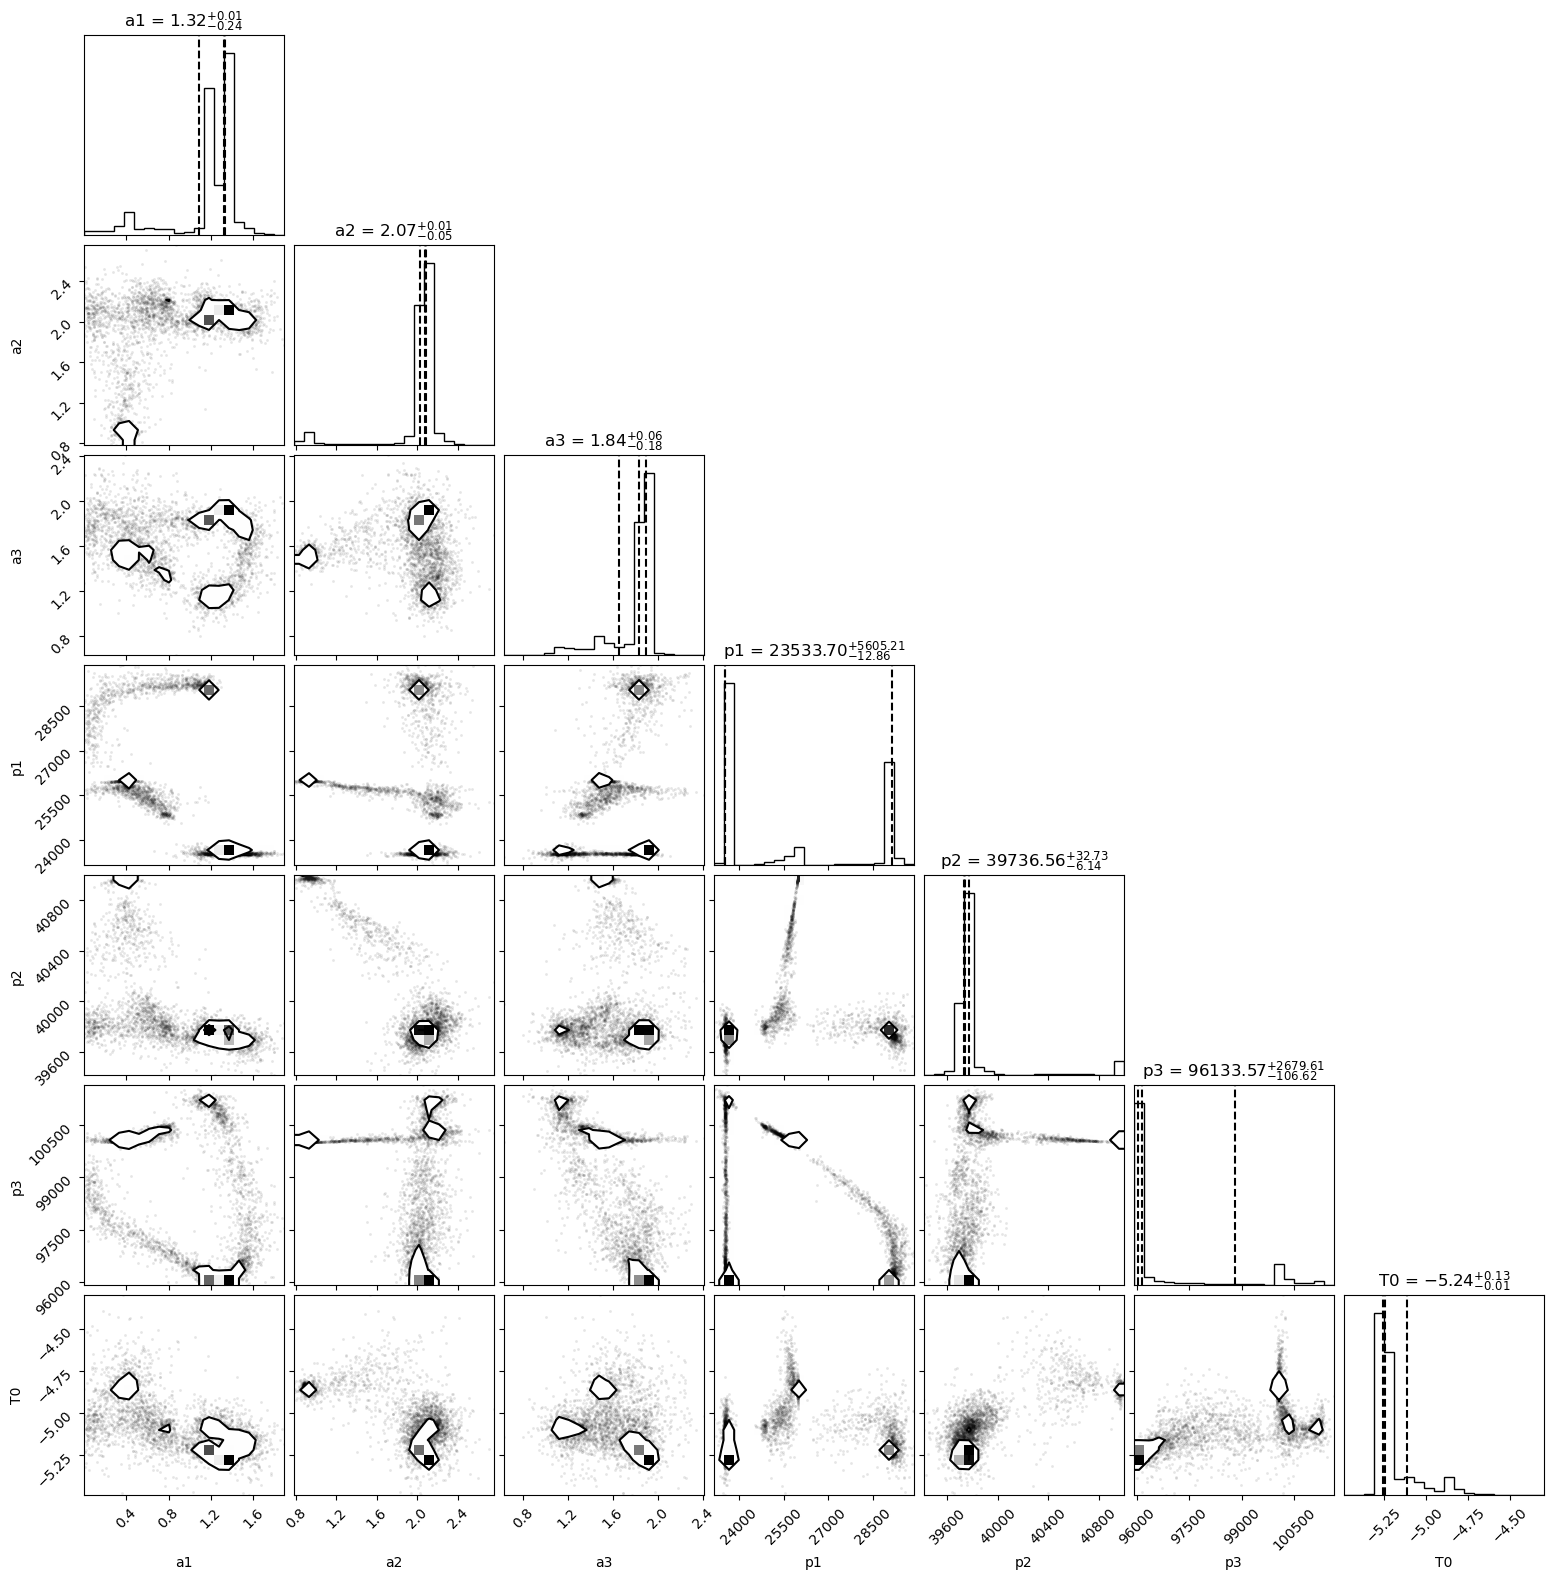

In [25]:
flat_samples=new_sampler.get_chain(thin=40,flat=True) 
#flat_samples=new_sampler.get_chain()
#(thin=10,flat=True) 
#again, we already re-set the sampler after 100 iterations of burn in.  So no need to discard.

print(flat_samples.shape)
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(flat_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
#fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

We can see that the secondary modes seems to be a lot better suppressed -- most of the models now favor a single value.  We also can see some cases -- e.g. $a_1$ -- where adding more walkers seems to have pushed MCMC to cluster around a different single mode result entirely!

Now let's plot a 2-$\sigma$ spread in posteriors about the maximum likelihood model. 

In [26]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
#med_model, spread = sample_walkers(100,new_samples)
med_model, spread = sample_walkers(100,flat_samples)

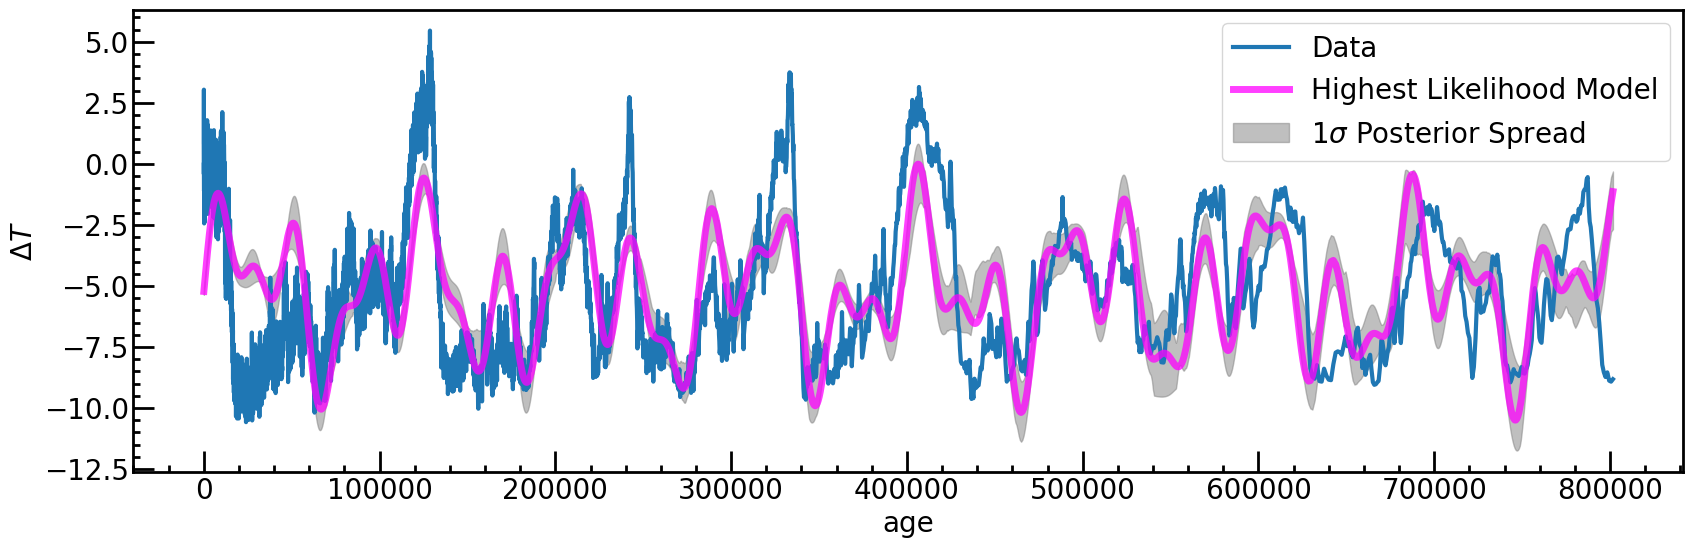

In [29]:
nspread=1 #two-sigma
fig,ax=plt.subplots(figsize=(20,6))
ax.plot(age,T,label='Data',lw=3)
ax.plot(age,new_best_fit_model,label='Highest Likelihood Model',color='magenta',lw=5,alpha=0.75)
ax.fill_between(age,med_model-nspread*spread,med_model+nspread*spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
#ax.plot(age,best_fit_model,label='(OLD) Highest Likelihood Model',color='orange',lw=5,alpha=0.75)
ax.set_xlabel('age',fontsize=20)
ax.set_ylabel(r'$\Delta T$',fontsize=20)
ax.tick_params(which='major',direction='in',width=2,length=15,labelsize=20)
ax.tick_params(which='minor',direction='in',width=2,length=5)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.legend(loc='best',fontsize=20)
for axl in ['top','bottom','left','right']:
      ax.spines[axl].set_linewidth(2)
        
#plt.plot(age,T,label='Change in T',lw=3)
#plt.plot(age,new_best_fit_model,label='Highest Likelihood Model',lw=3,color='magenta')
#plt.fill_between(age,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
#plt.legend(loc='best',fontsize=20)

So it looks like our most likely model + 1-$\sigma$ uncertainties do a pretty decent job of fitting the data.

